In [1]:
import requests 
import sys
import json
import time
import math
import signal
import numpy as np
import time

def signal_handler(sig, frame):
    global run
    print('You pressed Ctrl+C!')
    run = False
def rotate( vec, deg ):
    rad = 2 * math.pi / 360 * deg

    out = [0,0]

    out[0] = ( math.cos( rad ) * vec[0] - math.sin( rad ) * vec[1] )
    out[1] = ( math.sin( rad ) * vec[0] + math.cos( rad ) * vec[1] )

    return out
def set_vel(vel):
    OMNIDRIVE_URL = "http://" + ROBOTINOIP + "/data/omnidrive"
    r = requests.post(url = OMNIDRIVE_URL, params = PARAMS, json = vel )
    if r.status_code != requests.codes.ok:
        #print("Error: post to %s with params %s failed", OMNIDRIVE_URL, PARAMS)
        raise RuntimeError("Error: post to %s with params %s failed", OMNIDRIVE_URL, PARAMS)
def bumper():
    BUMPER_URL = "http://" + ROBOTINOIP + "/data/bumper"
    r = requests.get(url = BUMPER_URL, params = PARAMS)
    if r.status_code == requests.codes.ok:
        data = r.json()
        return data["value"]
    else:
        raise RuntimeError("Error: get from %s with params %s failed", BUMPER_URL, PARAMS)
def distances():
    DISTANCES_URL = "http://" + ROBOTINOIP + "/data/distancesensorarray"
    r = requests.get(url = DISTANCES_URL, params = PARAMS)
    if r.status_code == requests.codes.ok:
        data = r.json()
        return data
    else:
        raise RuntimeError("Error: get from %s with params %s failed", DISTANCES_URL, PARAMS)
def OdometryRead():
    ODOMETRY_URL = "http://" + ROBOTINOIP + "/data/odometry"
    r = requests.get(url = ODOMETRY_URL, params = PARAMS)
    if r.status_code == requests.codes.ok:
        data = r.json()
        return data
    else:
        raise RuntimeError("Error: get from %s with params %s failed", ODOMETRY_URL, PARAMS)
class PID:
    def __init__(self,kP,uAboveLimit,uUnderLimit):
        self.kP = kP
        self.uAboveLimit = uAboveLimit
        self.uUnderLimit = uUnderLimit
        
    def PidCal(self,Target,current):
        err = Target - current
        uP = self.kP * err
        u = uP
        
        if(u>self.uAboveLimit):
            u=self.uAboveLimit
        elif(u<self.uUnderLimit):
            u=self.uUnderLimit 
        else:
            u = u
        return u
# helper functions
def pt_to_pt_distance (pt1,pt2):
    distance = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
    return distance

# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1
# Hàm sau nếu phát hiện hai biến bằng nhau thì xuất ra 
# Tại trong quá trình tính toán của MCU có thể xuất ra những giá trị xấp sỉ 
def equalCompare(Value,ComValue):
    if(abs(Value - ComValue) < 0.001):
        return 1
    else :
        return 0
def QuadRantCheck(u,v):
    if(u>0 and v < 0) :
        return 1
    if (u<0 and v <0) :
        return 2
    if (u<0 and v >0):
        return 3
    if (u>0 and v>0) :
        return 4
    if (u>0 and equalCompare(v,0) == 1):
        return -1
    if (u<0 and equalCompare(v,0) == 1):
        return -3
    if (v<0 and equalCompare(u,0) == 1):
        return -2
    if (v>0 and equalCompare(u,0) == 1):
        return -4
    else :
        return 0

def opstacleAvoid( CurrQuad):
    dis = distances()
    # print(dis)
    dis1 = dis[0]
    dis2 = dis[1]
    dis3 = dis[2]
    dis4 = dis[3]
    dis5 = dis[4]
    dis6 = dis[5]
    dis7 = dis[6]
    # dis8 = dis[7]
    dis8 = 0.4
    dis9 = dis[8]
    Opsticle = 0
    if (CurrQuad == -1):
        HeadingDis = [dis1]
    elif (CurrQuad == 1):
        HeadingDis = [dis9]
    elif (CurrQuad == -2):
        HeadingDis = [dis8]
    elif (CurrQuad == 2):
        HeadingDis = [dis7]
    elif (CurrQuad == -3):
        HeadingDis = [dis6,dis5]
    elif (CurrQuad == 3):
        HeadingDis = [dis4]
    elif (CurrQuad == -4):
        HeadingDis = [dis3]
    elif (CurrQuad == 4):
        HeadingDis = [dis2]
    else:
        return 0
        
    for i in range(len(HeadingDis)):
        if HeadingDis[i] < 0.2: 
            Opsticle = 1
            break
        else :
            Opsticle = 0
    return Opsticle

def osticaleAvoid2(v,u):
    alpha =np.arctan2(v,u)*180/np.pi

    # print(alpha)
    dis = distances()
    # print(dis)
    dis1 = dis[0]
    dis2 = dis[1]
    dis3 = dis[2]
    dis4 = dis[3]
    dis5 = dis[4]
    dis6 = dis[5]
    dis7 = dis[6]
    dis8 = dis[7]
    # dis8 = 
    dis9 = dis[8]
    Opsticle = 0
    if (20>=alpha>-20):
        # print("ss1")
        HeadingDis = [dis1]
    elif (20<=alpha<60):
        # print("ss2")
        HeadingDis = [dis2]
    elif (60<=alpha<100):
        # print("ss3")
        HeadingDis = [dis3]
    elif (100<=alpha<140):
        # print("ss4")
        HeadingDis = [dis4]
    elif (140<=alpha<180)or(-180< alpha <= -140):
        # print("ss56")
        HeadingDis = [dis6,dis5]
    elif (-140<=alpha<-100):
        # print("ss7")
        HeadingDis = [dis7]
    elif (-100<=alpha<-60):
        # print("ss8")
        HeadingDis = [dis8]
    elif (-60<=alpha<-20):
        # print("ss9")
        HeadingDis = [dis9]
    else:
        return 0

    
    for i in range(len(HeadingDis)):
        if HeadingDis[i] < 0.25: 
            Opsticle = 1
            break
        else :
            Opsticle = 0
    return Opsticle 
def pure_pursuit_step (path, currentPos, lookAheadDis, LFindex,LastgoalPt) :
    # goalPt = [0,0]
    goalPt = LastgoalPt
    #Đầu tiên là chúng ta sẽ lấy giá trị hiện tại của robot về để tính toán 
    currentX = currentPos[0]
    currentY = currentPos[1]
    #Cập nhật các biến lastIndex và startIndex để robot biết đã qua những đoạn đường nào 
    #Biến intersection 
    lastFoundIndex = LFindex
    intersection = False
    startingIndex = lastFoundIndex

    for i in range (startingIndex,len(path) - 1):
        # Các điểm 1 2 lần lượt là các điểm ở trong mảng path sẽ tạo ra các đường thẳng 
        x1 = path[i][0] - currentX
        y1 = path[i][1] - currentY
        x2 = path[i+1][0] - currentX
        y2 = path[i+1][1] - currentY
        # Các công thức tính ra khoảng cách giữa hai điểm
        # Và công thức xác định xem có cắt đường tròn không
        dx = x2 - x1
        dy = y2 - y1
        dr = math.sqrt (dx**2 + dy**2)
        D = x1*y2 - x2*y1
        # discriminant để xác định xem có cắt vào đường tròn hay không
        # discriminant > 0 có cắt 
        # discriminant < 0 không cắt
        # discriminant = 0 tiếp tuyến
        discriminant = (lookAheadDis**2) * (dr**2) - D**2
        # Đoạn code tìm điểm cắt 
        if discriminant >= 0:
            # Tìm các điểm cắt trên đường thẳng
            sol_x1 = (D * dy + sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
            sol_x2 = (D * dy - sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
            sol_y1 = (- D * dx + abs(dy) * np.sqrt(discriminant)) / dr**2
            sol_y2 = (- D * dx - abs(dy) * np.sqrt(discriminant)) / dr**2

            # Đưa các điểm tìm được vào mảng và đưa nó về toạ độ thực bằng cách cộng vào các trục thực
            sol_pt1 = [sol_x1 + currentX, sol_y1 + currentY]
            sol_pt2 = [sol_x2 + currentX, sol_y2 + currentY]

            #Xác định các giá trị X Y mút giữa hai điểm trên quỷ đạo để xác định xem điểm cắt có nằm trong khoảng đó hay không
            minX = min(path[i][0], path[i+1][0])
            minY = min(path[i][1], path[i+1][1])
            maxX = max(path[i][0], path[i+1][0])
            maxY = max(path[i][1], path[i+1][1])

            # Xác định xem có điểm nào trong khoảng giữa hai điểm hay không
            # Nếu có thì kích biến intersectFound lên 1
            if (
                (minX <= sol_pt1[0] <= maxX and minY <= sol_pt1[1] <= maxY) 
                or (equalCompare(sol_pt1[0],minX) == 1 or equalCompare(sol_pt1[0],maxX) == 1 
                or equalCompare(sol_pt1[1],minY) == 1 or equalCompare(sol_pt1[1],maxY) == 1) 
                or (minX <= sol_pt2[0] <= maxX and minY <= sol_pt2[1] <= maxY) 
                or (equalCompare(sol_pt2[0],minX) == 1 or equalCompare(sol_pt2[0],maxX) == 1 
                or equalCompare(sol_pt2[1],minY) == 1 or equalCompare(sol_pt2[1],maxY) == 1)) :
                intersectFound = True 

                # TH 1 : Nếu cả hai điểm ở trong đều ở trong khoảng điểm :
                if (
                ((minX <= sol_pt1[0] <= maxX and minY <= sol_pt1[1] <= maxY) 
                or (equalCompare(sol_pt1[0],minX) == 1 or equalCompare(sol_pt1[0],maxX) == 1 
                or equalCompare(sol_pt1[1],minY) == 1 or equalCompare(sol_pt1[1],maxY) == 1)) 
                and ((minX <= sol_pt2[0] <= maxX and minY <= sol_pt2[1] <= maxY) 
                or (equalCompare(sol_pt2[0],minX) == 1 or equalCompare(sol_pt2[0],maxX) == 1 
                or equalCompare(sol_pt2[1],minY) == 1 or equalCompare(sol_pt2[1],maxY) == 1))) :# Chúng ta sẽ kiểm tra xem điểm nào gần điểm tiếp theo cần đến trong quỷ đạo hơn :
                    if pt_to_pt_distance(sol_pt1, path[i+1]) < pt_to_pt_distance(sol_pt2, path[i+1]):
                        goalPt = sol_pt1
                    else:
                        goalPt = sol_pt2

                # TH2 : Nếu chỉ có 1 trong hai điểm nằm trong khoảng :
                else :
                    if (
                    (minX <= sol_pt1[0] <= maxX and minY <= sol_pt1[1] <= maxY) 
                    or (equalCompare(sol_pt1[0],minX) == 1 or equalCompare(sol_pt1[0],maxX) == 1 
                    or equalCompare(sol_pt1[1],minY) == 1 or equalCompare(sol_pt1[1],maxY) == 1) ):
                        goalPt = sol_pt1
                    else:
                        goalPt = sol_pt2
                
                # Tính xem là khoảng cách của setpoint tới điểm tiếp theo xem có gần hơn với vị trí robot hay không :
                # Thoát giữ index để biết là hiện tại đang ở đoạn nào 
                
                if pt_to_pt_distance (goalPt, path[i+1]) < pt_to_pt_distance ([currentX, currentY], path[i+1]):
                    lastFoundIndex = i
                    break
                else :
                    if (lastFoundIndex == len(path -1)):
                        goalPt = [path[lastFoundIndex][0], path[lastFoundIndex][1]]
                    lastFoundIndex = i+1
            # Nếu không có điểm nào cắt :
            else :
                foundIntersection = False
                goalPt = [path[lastFoundIndex][0], path[lastFoundIndex][1]]

    # goalPt.append(path[lastFoundIndex][2])
    
    return goalPt,lastFoundIndex




def calculate_checkpoints(OdoX, OdoY, pathDesiried):
    checkpoint = 0
    num_points = pathDesiried.shape[0]
    Flag = 0
    while checkpoint < num_points:
        if abs(OdoX - pathDesiried[checkpoint, 0]) < 0.1 and abs(OdoY - pathDesiried[checkpoint, 1]) < 0.1:

            returnCheckpoint = np.array(pathDesiried[checkpoint])
            returnCheckpoint/=0.4
            returnCheckpoint[1] = -returnCheckpoint[1]
            returnCheckpoint = returnCheckpoint.astype(int)
            
            return returnCheckpoint


        checkpoint += 1
    return np.array([[100,100]])

In [26]:
def init():
    #Khai báo thông số Robot :
    global currentPos,lastFoundIndex,lookAheadDis
    lastFoundIndex = 0
    currentPos = [0, 0]
    lastFoundIndex = 0
    lookAheadDis = 0.1

    #Khai báo cờ phục vụ việc dừng robot :
    global msecsElapsed,goaltheta,msecStop,WaitFlag,StopFlag,EndFlag,DemonStrateFlag,msecDemon
    msecsElapsed = 0 
    goaltheta = 0
    msecStop= 0
    WaitFlag = 0
    StopFlag = 0
    EndFlag = 0
    msecDemon = 0
    DemonStrateFlag = 0
    
    #Khai báo thông số robot :
    global vec,pidX,pidY,pidTheta,goalPt
    vec = [0,0,0]
    pidX = PID(1.5,0.6,-0.6)
    pidY = PID(1.5,0.6,-0.6)
    pidTheta = PID(0.03,0.3,-0.3) 
    goalPt = [0,0]
    
# odo_data = []
def PathFollowing2(data,Heading = True):
    global msecsElapsed,goaltheta,msecStop,msecDemon,WaitFlag,StopFlag,EndFlag,DemonStrateFlag
    global currentPos,lastFoundIndex,lookAheadDis,goalPt,pathOdering
    global vec,pidX,pidY,pidTheta,goalPt

    
    try:
        Dataout = np.array(data)
        Dataout[:, 1] = -Dataout[:, 1]
        pathDesiried = Dataout.astype(float)
        pathDesiried*=0.4

        preCheckpoint = np.array([[100,100]])
        preErr = np.array([[0,0],[0,0]])
        returnCheckpointError = np.array([[1,0],[0,0]])
        returnCheckpoint = np.array([[0,0],[0,0]])
        checkpoint = 0
        ErrorFlag = 0
        signal.signal(signal.SIGINT, signal_handler)
        errIndex = 0
        # start_time = time.time()
        
        init()     
        while False == bumper() and True == run:
            # Đọc ví trí robot từ bộ đo đường 
            start_time = time.time()
            OdoX = OdometryRead()[0] 
            OdoY = OdometryRead()[1] 
            OdoR = OdometryRead()[2]
    
            # Cập nhật vị trí robot để đưa vào tính toán 
            currentPos = [OdoX,OdoY]
            goalPt,lastFoundIndex = pure_pursuit_step (pathDesiried, currentPos, lookAheadDis, lastFoundIndex,goalPt)


            # Đưa thông số vào bộ PID để tính toán cho robot chạy bám theo quỷ đạo 
            u = pidX.PidCal(goalPt[0],OdoX)
            v = pidY.PidCal(goalPt[1],OdoY)
            goaltheta = 0
            if(Heading):
                if (pathDesiried[len(data)-1,1]<pathDesiried[0,1]):
                    goaltheta = -90
                else :
                    goaltheta = 90
            
            # Sử dụng ma trận xoay để robot chạy xoay trên một đường thẳng 
            uControl = (math.cos(-OdoR)*u - math.sin(-OdoR)*v)
            vControl = (math.sin(-OdoR)*u + math.cos(-OdoR)*v)
            MoveFlag = osticaleAvoid2( vControl,uControl)

            vec[0] = uControl
            vec[1] = vControl
            vec[2] = pidTheta.PidCal(goaltheta,OdoR*180/math.pi)

            if (calculate_checkpoints(OdoX, OdoY, pathDesiried)!=np.array([[100,100]])).all() and (calculate_checkpoints(OdoX, OdoY, pathDesiried)!=preCheckpoint).all():

                returnCheckpoint = calculate_checkpoints(OdoX, OdoY, pathDesiried).tolist()
                yield returnCheckpoint
                # print(returnCheckpoint)
                errIndex = np.where((calculate_checkpoints(OdoX, OdoY, pathDesiried) == np.array(data)).all(axis=1))
                for index in errIndex[0]:
                    # print(index)
                    indexUse = index
            preCheckpoint = calculate_checkpoints(OdoX, OdoY, pathDesiried)
            
                
            if (lastFoundIndex == len(pathDesiried)-1):
                if (abs(goalPt[0] - OdoX)<0.05 and abs(goalPt[1] - OdoY)<0.05 ):
                    if EndFlag == 0:
                        EndFlag = 1 
                else :
                    EndFlag = 0
                    msecStop = msecsElapsed

            if(MoveFlag == 1):
                # data = np.array(data)
                yield np.array([data[indexUse],data[indexUse+1]]).tolist()
                # print( np.array([data[indexUse],data[indexUse+1]]).tolist())
                break
                
            if (msecsElapsed - msecStop > 1000) and EndFlag == 1 :
                break
            time.sleep(0.05)
            current_time = time.time()  # Thời điểm hiện tại
            if(start_time<current_time):
                elapsed_time = current_time - start_time  # Thời gian đã trôi qua
                preElapsed = elapsed_time
            else :
                elapsed_time = preElapsed
                
            msecsElapsed += int(elapsed_time * 1000) 
            odo_data.append([OdoX, OdoY, OdoR,msecsElapsed/1000,goalPt[0],goalPt[1],goaltheta])
            set_vel(vec)
        pathOdering  = np.array([[0,0]])
        set_vel([0,0,0])
    except Exception as e:
        print(e)
    # return returnCheckpoint

In [27]:
def init1():
    #Khai báo thông số Robot :
    global currentPos,lastFoundIndex,lookAheadDis
    lastFoundIndex = 0
    currentPos = [0, 0]
    lastFoundIndex = 0
    lookAheadDis = 0.1

    #Khai báo cờ phục vụ việc dừng robot :
    global msecsElapsed,goaltheta,msecStop,WaitFlag,StopFlag,EndFlag,DemonStrateFlag,msecDemon
    msecsElapsed = 0 
    goaltheta = 0
    msecStop= 0
    WaitFlag = 0
    StopFlag = 0
    EndFlag = 0
    msecDemon = 0
    DemonStrateFlag = 0
    
    #Khai báo thông số robot :
    global vec,pidX,pidY,pidTheta,goalPt
    vec = [0,0,0]
    pidX = PID(0.5,0.6,-0.6)
    pidY = PID(0.5,0.6,-0.6)
    pidTheta = PID(0.02,0.3,-0.3) 
    goalPt = [0,0]
    

def P2P(data):
    global msecsElapsed,goaltheta,msecStop,msecDemon,WaitFlag,StopFlag,EndFlag,DemonStrateFlag
    global currentPos,lastFoundIndex,lookAheadDis,goalPt,pathOdering
    global vec,pidX,pidY,pidTheta,goalPt

    
    try:
        
        init1()     
        preElapsed=0
        
        while False == bumper() and True == run:
            # Đọc ví trí robot từ bộ đo đường 
            start_time = time.time()
            
            OdoX = OdometryRead()[0] 
            OdoY = OdometryRead()[1] 
            OdoR = OdometryRead()[2]

            # Cập nhật vị trí robot để đưa vào tính toán 
            currentPos = [OdoX,OdoY]

            # Đưa thông số vào bộ PID để tính toán cho robot chạy bám theo quỷ đạo 
            u = pidX.PidCal(data[0],OdoX)
            v = pidY.PidCal(data[1],OdoY)
            goaltheta = data[2]

            if (abs(data[0] - OdoX)<0.01 and abs(data[1] - OdoY)<0.01 ):
                # and abs(goaltheta - OdoR*180/math.pi)<1):
                print([abs(data[0] - OdoX),abs(data[1] - OdoY),EndFlag])
                if EndFlag == 0:
                    EndFlag = 1 
            else :
                EndFlag = 0
                msecStop = msecsElapsed
                
            # Sử dụng ma trận xoay để robot chạy xoay trên một đường thẳng 
            uControl = (math.cos(-OdoR)*u - math.sin(-OdoR)*v)
            vControl = (math.sin(-OdoR)*u + math.cos(-OdoR)*v)
            MoveFlag = osticaleAvoid2( vControl,uControl)

            vec[0] = uControl
            vec[1] = vControl
            vec[2] = pidTheta.PidCal(goaltheta,OdoR*180/math.pi)

           
            if (msecsElapsed - msecStop > 1500) and EndFlag == 1 :
                break
                
            time.sleep(0.05)
            
            current_time = time.time()  # Thời điểm hiện tại
            if(start_time<current_time):
                elapsed_time = current_time - start_time  # Thời gian đã trôi qua
                preElapsed = elapsed_time
            else :
                elapsed_time = preElapsed
                
            msecsElapsed += int(elapsed_time * 1000) 
            # msecsElapsed+= 50
     
            odo_data.append([OdoX, OdoY, OdoR,msecsElapsed/1000,data[0],data[1],goaltheta])
            set_vel(vec)
        # pathOdering  = np.array([[0,0]])
        set_vel([0,0,0])
    except Exception as e:
        print(e)
        return 1
    return 0

In [28]:
def demonstrate():
    try:
        
        init1()     
        preElapsed=0
        while False == bumper() and True == run:
            start_time = time.time()

            vec[0] = 0
            vec[1] = 0
            vec[2] = 1

            if (msecsElapsed - msecStop > 5000) and EndFlag == 1 :
                break
                
            time.sleep(0.05)
            
            current_time = time.time()  # Thời điểm hiện tại
            if(start_time<current_time):
                elapsed_time = current_time - start_time  # Thời gian đã trôi qua
                preElapsed = elapsed_time
            else :
                elapsed_time = preElapsed
                
            msecsElapsed += int(elapsed_time * 1000) 
            # msecsElapsed+= 50
     
            odo_data.append([OdoX, OdoY, OdoR,msecsElapsed/1000,data[0],data[1],goaltheta])
            set_vel(vec)
        # pathOdering  = np.array([[0,0]])
        set_vel([0,0,0])
    except Exception as e:
        print(e)
        return 1
    return 0    

In [29]:
ROBOTINOIP = "192.168.87.210"
PARAMS = {'sid':'example_circle'}
run = True
odo_data = []
theta = 0
point1 = np.array([0,0,0*180/np.pi])
if __name__ == "__main__":
    # for data in PathFollowing2(Nhan_return):
    #     print(data)
    # time.sleep(1)
    for data in PathFollowing2(Nhan_return[::-1],False):
        print(data)
    # P2P(point1)
    print("Task Finished")

[3, 6]
[3, 5]
[3, 4]
[3, 3]
[3, 2]
[3, 1]
[3, 0]
[2, 0]
[[2, 0], [1, 0]]
Task Finished


In [5]:
Nhan_return = [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)]

def DataProcess(data):
    Dataout = np.array(data)
    Dataout[:, 1] = -Dataout[:, 1]
    return Dataout
dataTest = DataProcess(Nhan_return)


dataTest

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 3, -1],
       [ 3, -2],
       [ 3, -3],
       [ 3, -4],
       [ 3, -5],
       [ 3, -6]])

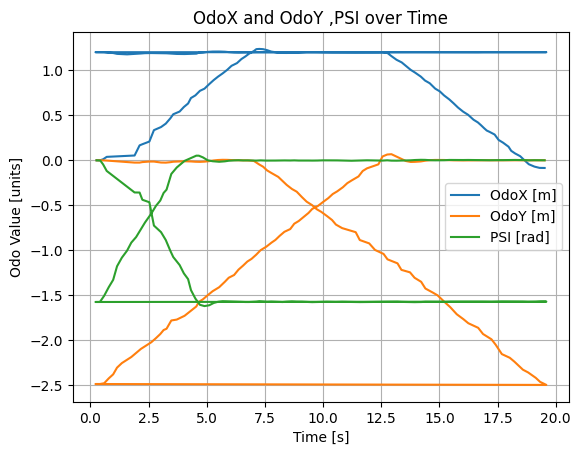

In [192]:
import matplotlib.pyplot as plt
t = [data[3] for data in odo_data]  # Tạo một dãy thời gian từ 0 đến chiều dài của odo_data
t1 = range(len(odo_data)) 
X = [data[0] for data in odo_data]  # Lấy giá trị OdoX từ odo_data
Y = [data[1] for data in odo_data]  # Lấy giá trị OdoY từ odo_data
PSI = [data[2] for data in odo_data]
plt.plot(t, X)  # Vẽ đồ thị OdoX theo thời gian
plt.plot(t, Y)  # Vẽ đồ thị OdoY theo thời gian
plt.plot(t, PSI)  # Vẽ đồ thị OdoY theo thời gian

# plt.plot(t, X)  # Vẽ đồ thị OdoX theo thời gian
# plt.plot(t, Y)  # Vẽ đồ thị OdoY theo thời gian
# plt.plot(t, PSI)  # Vẽ đồ thị OdoY theo thời gian
plt.xlabel('Time [s]')
plt.ylabel('Odo Value [units]')
plt.title('OdoX and OdoY ,PSI over Time')

plt.grid(True)  # Bật lưới
plt.legend(['OdoX [m]', 'OdoY [m]','PSI [rad]'])  # Chú thích cho các đường đồ thị
plt.show()

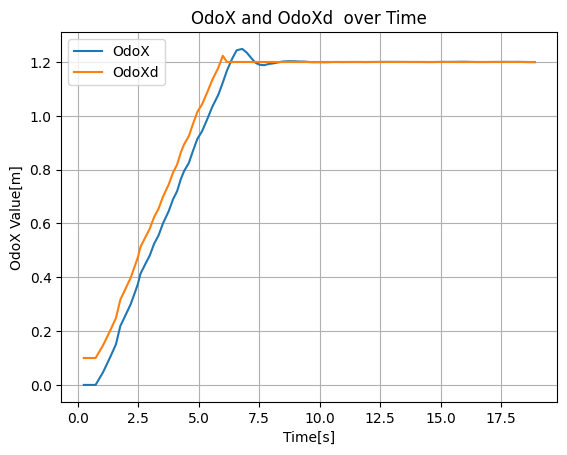

In [180]:
t = [data[3] for data in odo_data]  # Tạo một dãy thời gian từ 0 đến chiều dài của odo_data
t1 = range(len(odo_data)) 
X = [data[0] for data in odo_data]  # Lấy giá trị OdoX từ odo_data
Xd = [data[4] for data in odo_data]  # Lấy giá trị OdoY từ odo_data
# PSI = [data[2] for data in odo_data]
plt.plot(t, X)  # Vẽ đồ thị OdoX theo thời gian
plt.plot(t, Xd)  # Vẽ đồ thị OdoY theo thời gian

# plt.plot(t, X)  # Vẽ đồ thị OdoX theo thời gian
# plt.plot(t, Xd)  # Vẽ đồ thị OdoY theo thời gian
# plt.plot(t, PSI)  # Vẽ đồ thị OdoY theo thời gian
plt.xlabel('Time[s]')
plt.ylabel('OdoX Value[m]')
plt.title('OdoX and OdoXd  over Time')

plt.grid(True)  # Bật lưới
plt.legend(['OdoX', 'OdoXd'])  # Chú thích cho các đường đồ thị
plt.show()

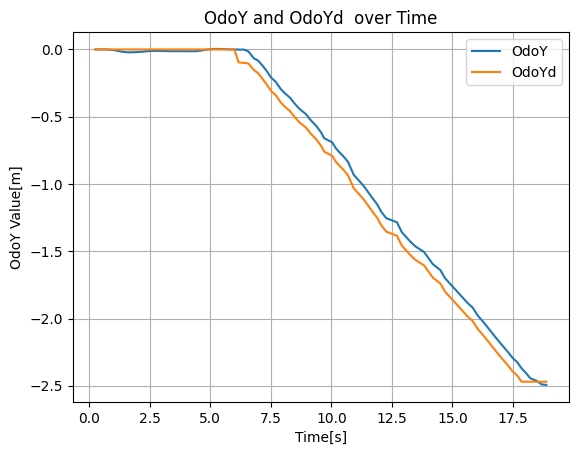

In [181]:
t = [data[3] for data in odo_data]  # Tạo một dãy thời gian từ 0 đến chiều dài của odo_data
t1 = range(len(odo_data)) 
Y = [data[1] for data in odo_data]  # Lấy giá trị OdoX từ odo_data
Yd = [data[5] for data in odo_data]  # Lấy giá trị OdoY từ odo_data
# PSI = [data[2] for data in odo_data]
plt.plot(t, Y)  # Vẽ đồ thị OdoX theo thời gian
plt.plot(t, Yd)  # Vẽ đồ thị OdoY theo thời gian

# plt.plot(t, Y)  # Vẽ đồ thị OdoX theo thời gian
# plt.plot(t, Yd)  # Vẽ đồ thị OdoY theo thời gian
# plt.plot(t, PSI)  # Vẽ đồ thị OdoY theo thời gian
plt.xlabel('Time[s]')
plt.ylabel('OdoY Value[m]')
plt.title('OdoY and OdoYd  over Time')

plt.grid(True)  # Bật lưới
plt.legend(['OdoY', 'OdoYd'])  # Chú thích cho các đường đồ thị
plt.show()

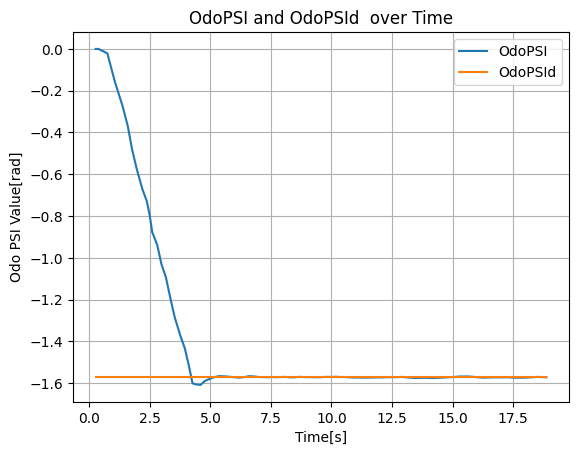

In [182]:
t = [data[3] for data in odo_data]  # Tạo một dãy thời gian từ 0 đến chiều dài của odo_data
t1 = range(len(odo_data)) 
PSI = [data[2] for data in odo_data]  # Lấy giá trị OdoX từ odo_data
PSId = np.array([data[6]*np.pi/180 for data in odo_data], dtype=float)  # Lấy giá trị OdoY từ odo_data
# PSId = PSId[:]
# PSI = [data[2] for data in odo_data]
plt.plot(t, PSI)  # Vẽ đồ thị OdoX theo thời gian
plt.plot(t, PSId)  # Vẽ đồ thị OdoY theo thời gian

# plt.plot(t, PSI)  # Vẽ đồ thị OdoX theo thời gian
# plt.plot(t, PSId)  # Vẽ đồ thị OdoY theo thời gian
# plt.plot(t, PSI)  # Vẽ đồ thị OdoY theo thời gian
plt.xlabel('Time[s]')
plt.ylabel('Odo PSI Value[rad]')
plt.title('OdoPSI and OdoPSId  over Time')

plt.grid(True)  # Bật lưới
plt.legend(['OdoPSI', 'OdoPSId'])  # Chú thích cho các đường đồ thị
plt.show()

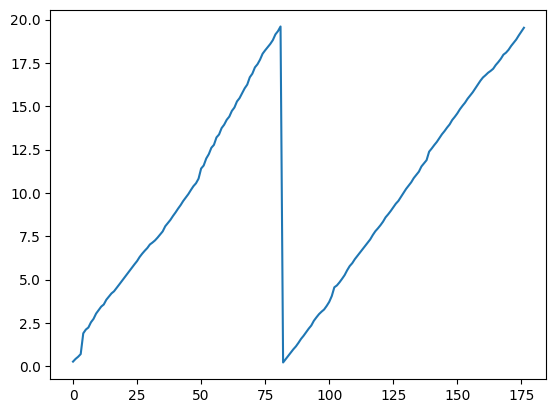

In [193]:
t = [data[3] for data in odo_data]  # Tạo một dãy thời gian từ 0 đến chiều dài của odo_data
t1 = range(len(odo_data)) 
plt.plot(t1, t)
plt.show()

In [194]:
t


[0.264,
 0.42,
 0.544,
 0.699,
 1.896,
 2.112,
 2.231,
 2.532,
 2.728,
 3.033,
 3.238,
 3.436,
 3.559,
 3.833,
 4.015,
 4.197,
 4.32,
 4.509,
 4.705,
 4.902,
 5.108,
 5.297,
 5.485,
 5.683,
 5.879,
 6.064,
 6.299,
 6.49,
 6.661,
 6.817,
 7.021,
 7.131,
 7.256,
 7.418,
 7.593,
 7.776,
 8.073,
 8.255,
 8.437,
 8.662,
 8.866,
 9.089,
 9.293,
 9.529,
 9.727,
 9.925,
 10.162,
 10.385,
 10.552,
 10.819,
 11.402,
 11.577,
 11.982,
 12.233,
 12.6,
 12.769,
 13.199,
 13.367,
 13.736,
 13.933,
 14.216,
 14.398,
 14.726,
 14.923,
 15.275,
 15.464,
 15.747,
 16.03,
 16.244,
 16.667,
 16.875,
 17.238,
 17.418,
 17.685,
 18.026,
 18.224,
 18.406,
 18.591,
 18.812,
 19.141,
 19.33,
 19.598,
 0.214,
 0.405,
 0.587,
 0.785,
 0.976,
 1.142,
 1.349,
 1.574,
 1.756,
 1.962,
 2.167,
 2.346,
 2.618,
 2.816,
 3.001,
 3.144,
 3.27,
 3.475,
 3.709,
 4.045,
 4.551,
 4.659,
 4.835,
 5.037,
 5.251,
 5.533,
 5.777,
 5.944,
 6.174,
 6.363,
 6.561,
 6.743,
 6.925,
 7.123,
 7.314,
 7.565,
 7.785,
 7.951,
 8.133,
 8.3

In [118]:
time.time()

1704535689.6706553